In [34]:
!pip install statsmodels

In [35]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [36]:
# Create array of category names as they appear in the detections data. See paper for details of each category.
categories = ['car', 'person', 'trotro', 'stall', 'truck', 'stove', 'motorcycle', 'vendor', 'lorry', 'umbrella', 'bus', 'trash', 'taxi', 'van', 'debris', 'loudspeaker', 'bowl', 'food', 'animal', 'bicycle']

# Column names in the data frame for the number of counts of each category type in an image.
count_cols = [cat+'_counts' for cat in categories]

super_count_cols = ['people'+'_counts', 'small_vehicles'+'_counts', 'two_wheelers'+'_counts', 'large_vehicles'+'_counts', 'refuse'+'_counts', 'market'+'_counts', 'animal'+'_counts']

all_count_cols = count_cols + super_count_cols

vehicle_categories = ['car', 'trotro', 'truck', 'motorcycle', 'lorry', 'bus', 'taxi', 'van', 'bicycle']

# Define super categories
super_categories = {
    'people': ['person', 'vendor'],
    'small_vehicles': ['car', 'taxi', 'truck'],
    'two_wheelers': ['bicycle', 'motorcycle'],
    'large_vehicles': ['trotro', 'van', 'lorry', 'bus'],
    'refuse': ['trash', 'debris'],
    'market': ['umbrella', 'stall', 'bowl', 'food'],
    'animal': ['animal']
}

In [3]:
# # Load the model coefficients from the CSV file
# site = 'ASH'
# model_df = pd.read_csv(f'./{site}_model_coefficients.csv')



In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to plot total hour effects
def plot_total_hour_effects(model_df, hour_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = []
    lower_bounds = []
    upper_bounds = []
    
    for hour in range(1, 24):
        main_term = f'hour{hour}'
        row = model_df[model_df['term'] == main_term]
        
        if not row.empty:
            coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
            estimates.append(coef)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        else:
            estimates.append(np.nan)
            lower_bounds.append(np.nan)
            upper_bounds.append(np.nan)
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(hour_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Hour Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(hour_labels)), labels=hour_labels, rotation=45)
    plt.xlabel('Hour of Day')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_hour_effects.png', bbox_inches='tight')
    plt.close()

# Function to plot total day effects, including interaction terms
def plot_total_day_effects(model_df, day_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = []
    lower_bounds = []
    upper_bounds = []
    
    for day_idx, day in enumerate(day_labels, start=1):
        if day == 'Mon':
            estimates.append(1)
            lower_bounds.append(1)
            upper_bounds.append(1)
        else:
            main_term = f'day{day_idx}'
            main_row = model_df[model_df['term'] == main_term]
            
            interaction_estimates = []
            interaction_lowers = []
            interaction_uppers = []
            
            # Combine hour interaction effects for the given day
            for hour in range(1, 24):
                interaction_term = f'hour{hour}:day{day_idx}'
                interaction_row = model_df[model_df['term'] == interaction_term]
                
                if not main_row.empty and not interaction_row.empty:
                    combined_estimate, combined_lower, combined_upper = combine_main_and_interaction_effects(
                        main_row.iloc[0], interaction_row
                    )
                    interaction_estimates.append(combined_estimate)
                    interaction_lowers.append(combined_lower)
                    interaction_uppers.append(combined_upper)
            
            if interaction_estimates:
                avg_estimate = np.mean(interaction_estimates)
                avg_lower = np.mean(interaction_lowers)
                avg_upper = np.mean(interaction_uppers)
                estimates.append(avg_estimate)
                lower_bounds.append(avg_lower)
                upper_bounds.append(avg_upper)
            else:
                estimates.append(np.nan)
                lower_bounds.append(np.nan)
                upper_bounds.append(np.nan)
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(day_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Day Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(day_labels)), labels=day_labels, rotation=45)
    plt.xlabel('Day of Week')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_day_effects.png', bbox_inches='tight')
    plt.close()

# Function to plot total year effects
def plot_total_year_effects(model_df, year_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = []
    lower_bounds = []
    upper_bounds = []
    
    for year_label in year_labels:
        main_term = f'year{year_label}'
        row = model_df[model_df['term'] == main_term]
        
        if not row.empty:
            coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
            estimates.append(coef)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        else:
            estimates.append(np.nan)
            lower_bounds.append(np.nan)
            upper_bounds.append(np.nan)
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(year_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Year Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(year_labels)), labels=year_labels, rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_year_effects.png', bbox_inches='tight')
    plt.close()

# Function to plot total week effects
def plot_total_week_effects(model_df, week_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = []
    lower_bounds = []
    upper_bounds = []
    
    for week_label in week_labels:
        main_term = f'week{week_label}'
        row = model_df[model_df['term'] == main_term]
        
        if not row.empty:
            coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
            estimates.append(coef)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        else:
            estimates.append(np.nan)
            lower_bounds.append(np.nan)
            upper_bounds.append(np.nan)
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(week_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Week Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(week_labels)), labels=week_labels, rotation=45)
    plt.xlabel('Week')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_week_effects.png', bbox_inches='tight')
    plt.close()

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal'] 

for site in sites:
    for super_category in super_categories:
        model_df = pd.read_csv(f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv')
        
        # Plot total hour effects
        hour_labels = [f'Hour {i}' for i in range(1, 24)]
        plot_total_hour_effects(
            model_df, 
            hour_labels, 
            f'Total Effect of Hour on {super_category.capitalize()} Counts', 
            site, 
            super_category
        )
        
        # Plot total day effects


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to plot total year effects
def plot_total_year_effects(model_df, year_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = []
    lower_bounds = []
    upper_bounds = []
    
    for year in range(len(year_labels)):
        main_term = f'year{year_labels[year]}'
        row = model_df[model_df['term'] == main_term]
        
        if not row.empty:
            coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
            estimates.append(coef)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        else:
            estimates.append(np.nan)
            lower_bounds.append(np.nan)
            upper_bounds.append(np.nan)
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(year_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Year Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(year_labels)), labels=year_labels, rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_year_effects.png', bbox_inches='tight')
    plt.close()

# Function to plot total week effects
def plot_total_week_effects(model_df, week_labels, title, site, super_category):
    plt.figure(figsize=(12, 6))
    
    estimates = []
    lower_bounds = []
    upper_bounds = []
    
    for week in range(len(week_labels)):
        main_term = f'week{week + 2}'  # Week 1 is the reference, so start from week 2
        row = model_df[model_df['term'] == main_term]
        
        if not row.empty:
            coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
            estimates.append(coef)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        else:
            estimates.append(np.nan)
            lower_bounds.append(np.nan)
            upper_bounds.append(np.nan)
    
    # Plot the effects with error bars
    plt.errorbar(
        range(len(week_labels)), 
        estimates, 
        yerr=[np.array(estimates) - np.array(lower_bounds), np.array(upper_bounds) - np.array(estimates)], 
        fmt='o', 
        capsize=5,
        label=f'Total Week Effects'
    )
    
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.xticks(ticks=range(len(week_labels)), labels=week_labels, rotation=45)
    plt.xlabel('Week')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Save the figure
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_week_effects.png', bbox_inches='tight')
    plt.close()

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal'] 

for site in sites:
    for super_category in super_categories:
        model_df = pd.read_csv(f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv')
        
        # Plot total year effects
        year_labels = ['2020', '2021', '2022', '2023', '2024']  # Assuming '2019' as the reference
        plot_total_year_effects(
            model_df, 
            year_labels, 
            f'Total Effect of Year on {super_category.capitalize()} Counts', 
            site, 
            super_category
        )
        
        # Plot total week effects
        week_labels = [f'Week {i}' for i in range(2, 54)]  # Week 1 is the reference category
        plot_total_week_effects(
            model_df, 
            week_labels, 
            f'Total Effect of Week on {super_category.capitalize()} Counts', 
            site, 
            super_category
        )


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to plot hour effects stratified by day of the week
def plot_hour_effects_by_day(model_df, hour_labels, title, site, super_category, show_whiskers=True):
    plt.figure(figsize=(12, 6))

    # Days of the week mapping (assuming 1 = Monday, 2 = Tuesday, etc.)
    days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    all_estimates = []  # List to keep track of all estimates across all days

    for day_idx, day in enumerate(days_of_week, start=1):
        estimates = []
        lower_bounds = []
        upper_bounds = []
        hour_indices = []

        if day == 'Mon':
            # For Monday, use the main effects
            for hour in range(1, 24):
                term = f'hour{hour}'
                row = model_df[model_df['term'] == term]
                if not row.empty:
                    coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
                    estimates.append(coef)
                    lower_bounds.append(lower)
                    upper_bounds.append(upper)
                    hour_indices.append(hour-1)  # Store hour index for connecting lines
                else:
                    # Handle missing data
                    estimates.append(np.nan)
                    lower_bounds.append(np.nan)
                    upper_bounds.append(np.nan)
                    hour_indices.append(hour-1)  # Maintain hour index for consistency
        else:
            # For other days, combine main effects with interaction effects
            for hour in range(1, 24):
                main_term = f'hour{hour}'
                inter_term = f'hour{hour}:day{day_idx}'
                
                main_row = model_df[model_df['term'] == main_term]
                inter_row = model_df[model_df['term'] == inter_term]
                
                if not main_row.empty and not inter_row.empty:
                    main_coef, main_lower, main_upper = calculate_effects_and_ci(main_row.iloc[0])
                    inter_coef, inter_lower, inter_upper = calculate_effects_and_ci(inter_row.iloc[0])
                    
                    # Combine estimates in log space
                    combined_estimate = np.exp(np.log(main_coef) + np.log(inter_coef))
                    combined_lower = np.exp(np.log(main_lower) + np.log(inter_lower))
                    combined_upper = np.exp(np.log(main_upper) + np.log(inter_upper))
                    
                    estimates.append(combined_estimate)
                    lower_bounds.append(combined_lower)
                    upper_bounds.append(combined_upper)
                    hour_indices.append(hour-1)  # Store hour index for connecting lines
                else:
                    # Handle missing data
                    estimates.append(np.nan)
                    lower_bounds.append(np.nan)
                    upper_bounds.append(np.nan)
                    hour_indices.append(hour-1)  # Maintain hour index for consistency

        # Convert lists to numpy arrays and remove any NaN values before plotting
        estimates = np.array(estimates)
        lower_bounds = np.array(lower_bounds)
        upper_bounds = np.array(upper_bounds)
        hour_indices = np.array(hour_indices)  # Convert hour indices to numpy array
        
        valid_indices = ~np.isnan(estimates)
        
        estimates = estimates[valid_indices]
        lower_bounds = lower_bounds[valid_indices]
        upper_bounds = upper_bounds[valid_indices]
        valid_hour_indices = hour_indices[valid_indices]  # Filter hour indices to match valid estimates
        valid_hour_labels = np.array(hour_labels)[valid_indices]

        # Store all estimates for y-axis limit calculation
        all_estimates.extend(estimates)

        if len(estimates) > 0:
            if show_whiskers:
                plt.errorbar(
                    valid_hour_indices, 
                    estimates, 
                    yerr=[estimates - lower_bounds, upper_bounds - estimates], 
                    fmt='none', 
                    capsize=5,
                    alpha=0.125,  # Faint whiskers
                    elinewidth=1.5,
                    ecolor='blue',  # Default color for whiskers
                    errorevery=1,
                    capthick=1.5
                )
            
            # Plot the central points with full visibility
            plt.errorbar(
                valid_hour_indices, 
                estimates, 
                yerr=None,  # No whiskers here
                fmt='o', 
                capsize=5,
                label=f'Day: {day}',
                alpha=1.0,  # Fully visible central points
                markersize=12,
                elinewidth=1.5,
                errorevery=1,
                capthick=1.5
            )
            
            # Plot lines connecting points
            plt.plot(
                valid_hour_indices, 
                estimates, 
                linestyle='-', 
                color=plt.gca().lines[-1].get_color(),  # Use the same color as the points
                alpha=0.75,  # Slightly transparent line
                linewidth=2
            )

    # Adding a thicker black line at y=1 to represent the reference level
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    
    # Adjust y-axis limit to focus on the central tendency
    if all_estimates:
        max_estimate = max(all_estimates)
        plt.ylim(0, max_estimate * 1.1)  # Set the upper limit to 1.1 times the max estimate

    plt.xticks(ticks=range(len(valid_hour_labels)), labels=valid_hour_labels, rotation=45)
    plt.xlabel('Hour of Day')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    # Create directory if it doesn't exist
    output_dir = f'./results/time_series/{site}/{super_category}/'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the figure
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_hour_by_day.png', bbox_inches='tight')
    plt.close()

# Loop over all files matching the pattern in each fold directory
fold_directories = [f'interaction_fold_{i}' for i in range(1, 6)]

sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH']
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

for site in tqdm(sites):  # Loop over each site
    for super_category in super_categories:
        
        model_dfs = {}
        for fold in range(1, 6):
            fold_dir = f'interaction_fold_{fold}'
            filepath = f'{fold_dir}/{site}_{super_category}_fold_{fold}_conditional_model_coefficients.csv'
            if os.path.exists(filepath):
                model_dfs[fold] = pd.read_csv(filepath)
        
        if model_dfs:
            # Using the first fold to determine available terms
            first_model_df = model_dfs[1]  
            hour_labels = [f'Hour {i}' for i in range(1, 24)]
            
            # Plot the effects of hour stratified by day of the week
            plot_hour_effects_by_day(
                first_model_df, 
                hour_labels,
                f'Effect of Hour of Day Stratified by Day (Interaction) - {super_category.capitalize()}',
                site,
                super_category,
                show_whiskers=True  # Turn whiskers on or off
            )


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.05s/it]


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import r2_score
from tqdm import tqdm

# Function to calculate R² values across folds
def calculate_r2_across_folds(true_values, predicted_values):
    r2_values = []
    for true, predicted in zip(true_values, predicted_values):
        r2_values.append(r2_score(true, predicted))
    return r2_values

# Function to plot true vs predicted values for a site and super category
def plot_true_vs_predicted(site, super_category, true_values, predicted_values, title, output_dir):
    plt.figure(figsize=(8, 8))
    
    # Plotting each fold with different colors and lower alpha for transparency
    for i, (true, predicted) in enumerate(zip(true_values, predicted_values), start=1):
        plt.scatter(true, predicted, label=f'Fold {i}', alpha=0.3, s=20)  # Lower alpha for better visibility
    
    # Plotting the x=y reference line
    min_val = min(min([min(t) for t in true_values]), min([min(p) for p in predicted_values]))
    max_val = max(max([max(t) for t in true_values]), max([max(p) for p in predicted_values]))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    
    # Calculating R² values
    all_true = np.concatenate(true_values)
    all_predicted = np.concatenate(predicted_values)
    overall_r2 = r2_score(all_true, all_predicted)
    fold_r2_values = calculate_r2_across_folds(true_values, predicted_values)
    
    # Annotating the plot with R² values
    plt.text(0.05, 0.95, f'Overall R²: {overall_r2:.2f}\n'
                         f'Min R²: {min(fold_r2_values):.2f}\n'
                         f'Mean R²: {np.mean(fold_r2_values):.2f}\n'
                         f'Max R²: {max(fold_r2_values):.2f}', 
             fontsize=12, verticalalignment='top', transform=plt.gca().transAxes)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 0))  # Adjust legend location to avoid overlap with R² text
    plt.grid(True)
    
    # Ensuring the plot is on the same scale
    plt.xlim([min_val, max_val])
    plt.ylim([min_val, max_val])
    
    # Save the figure
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}.png', bbox_inches='tight')
    plt.close()

# Main function to process all folds and plot results
def process_and_plot(site, super_category, folds_dir, output_dir):
    true_values_fixed_only = []
    predicted_values_fixed_only = []
    true_values_with_random = []
    predicted_values_with_random = []
    
    for fold in range(1, 6):
        file_path = f'{folds_dir}/fold_{fold}/{site}_{super_category}_fold_{fold}_model_predictions.csv'
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            true_values_fixed_only.append(data[f'{super_category}_counts'].values)
            predicted_values_fixed_only.append(data['predicted_counts_fixed_only'].values)
            true_values_with_random.append(data[f'{super_category}_counts'].values)
            predicted_values_with_random.append(data['predicted_counts_with_random'].values)
    
    if true_values_fixed_only and predicted_values_fixed_only:
        # Plot for fixed-only effects
        plot_true_vs_predicted(site, super_category, true_values_fixed_only, predicted_values_fixed_only, 
                               f'True vs Predicted (Fixed Effects Only) - {super_category.capitalize()}', 
                               f'{output_dir}/{site}/{super_category}')
        
    if true_values_with_random and predicted_values_with_random:
        # Plot for fixed and random effects
        plot_true_vs_predicted(site, super_category, true_values_with_random, predicted_values_with_random, 
                               f'True vs Predicted (Fixed and Random Effects) - {super_category.capitalize()}', 
                               f'{output_dir}/{site}/{super_category}')

# Example usage:
output_directory = './results/time_series'
folds_directory = './'

# Assuming you have site names and super categories
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH']
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

for site in tqdm(sites):
    for super_category in super_categories:
        process_and_plot(site, super_category, folds_directory, output_directory)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.73s/it]


In [54]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# Function to calculate the central coefficient (estimate)
def calculate_effects(row):
    return row['estimate']

# Function to normalize the data array
def normalize_array(array):
    """Normalize each row of the array to be between 0 and 1."""
    array_min = np.nanmin(array, axis=1, keepdims=True)  # Find min for each row
    array_max = np.nanmax(array, axis=1, keepdims=True)  # Find max for each row
    
    # Handle edge cases where min == max (will result in NaNs)
    normalized_array = (array - array_min) / (array_max - array_min)
    
    # If a row has the same min and max, set the entire row to 0.5, but NaN will be replaced with -1
    normalized_array = np.nan_to_num(normalized_array, nan=-1.0)
    
    return normalized_array

# Function to create data arrays for each time unit
def create_data_array_for_time_unit(model_dfs, time_vars, sites, super_category):
    data_array = []
    
    for site in sites:  # Iterate over the predefined site order
        site_data = [1]  # Start with the reference class (set to 1)
        for time_var in time_vars:
            estimates = []
            for fold, site_dfs in model_dfs.items():
                df_key = f'{site}_{super_category}'
                if df_key in site_dfs:
                    df = site_dfs[df_key]
                    # Check if the 'term' column has the correct time variable
                    term_rows = df[df['term'] == time_var]
                    if not term_rows.empty:
                        estimates.append(calculate_effects(term_rows.iloc[0]))  # Extract the coefficient for this fold
            if estimates:
                avg_estimate = np.mean(estimates)  # Average the estimates over folds
            else:
                avg_estimate = np.nan  # If no estimates found, return nan
            site_data.append(avg_estimate)
        data_array.append(site_data)
    
    data_array = np.array(data_array)
    
    # Normalize the data array row-wise
    normalized_data_array = normalize_array(data_array)
    
    return normalized_data_array

# Load model data for all folds
fold_directories = [f'fold_{i}' for i in range(1, 6)]
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

# Define time unit labels for hour, day, week, and year
time_unit_definitions = {
    'hour': [f'hour{i}' for i in range(1, 24)],  # 24 hours in a day
    'day': [f'day{i}' for i in range(2, 8)],  # 7 days in a week (assuming day1 is reference)
    'week': [f'week{i}' for i in range(2, 53)],  # 52 weeks in a year (Week 1 assumed to be reference)
    'year': [f'year{i}' for i in range(2020, 2025)]  # Assuming 2019 is the reference year
}

# Initialize model_dfs to store data for all folds
model_dfs = {}
for fold in range(1, 6):
    model_dfs[fold] = {}  # Initialize for each fold
    for site in sites:
        for super_category in super_categories:
            filepath = f'{fold_directories[fold - 1]}/{site}_{super_category}_fold_{fold}_conditional_model_coefficients.csv'
            if os.path.exists(filepath):
                model_dfs[fold][f'{site}_{super_category}'] = pd.read_csv(filepath)

# Ensure the order of site processing in the arrays matches the given site order
for super_category in super_categories:
    for time_unit, time_vars in time_unit_definitions.items():
        data_array = create_data_array_for_time_unit(model_dfs, time_vars, sites, super_category)
        
        # Ensure that rows (sites) are in the same order
        print(f"Object Category: {super_category}, Time Unit: {time_unit}")
        for site, row in zip(sites, data_array):
            print(f"{site}: {row}")
        print("\n" + "-"*40 + "\n")


Object Category: people, Time Unit: hour
AD: [1.42199442e-02 4.68116767e-03 6.36968919e-04 0.00000000e+00
 5.89365573e-03 3.66414180e-02 4.65222783e-01 7.38909979e-01
 7.90821162e-01 8.26828309e-01 8.21818874e-01 8.22925445e-01
 8.40264900e-01 8.46537176e-01 8.30327576e-01 8.16425705e-01
 8.33496765e-01 1.00000000e+00 8.11661955e-01 1.30701850e-01
 8.42595141e-02 5.89530831e-02 3.67221069e-02 2.01792334e-02]
ASH: [2.36512093e-02 3.69077386e-03 0.00000000e+00 4.16043220e-04
 7.41094065e-03 7.39350120e-02 4.01616374e-01 7.87376797e-01
 8.84718041e-01 8.24993258e-01 7.96445757e-01 7.12122810e-01
 6.62797188e-01 6.61462474e-01 6.26976781e-01 7.50492959e-01
 9.06504036e-01 1.00000000e+00 9.85956449e-01 4.68760917e-01
 3.81725040e-01 3.06603318e-01 1.73758387e-01 6.35326280e-02]
EL: [5.94540786e-02 2.42647380e-02 9.40638171e-03 3.17709643e-04
 0.00000000e+00 3.24741753e-02 4.99830163e-01 8.21411947e-01
 7.42401685e-01 6.95190808e-01 6.95318667e-01 7.08910286e-01
 7.21085602e-01 7.10695796e-0

In [79]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# Function to calculate the central coefficient (estimate)
def calculate_effects(row):
    return row['estimate']

# Function to normalize the data array
def normalize_array(array):
    """Normalize each row of the array to be between 0 and 1."""
    array_min = np.nanmin(array, axis=1, keepdims=True)  # Find min for each row
    array_max = np.nanmax(array, axis=1, keepdims=True)  # Find max for each row
    
    # Handle edge cases where min == max (will result in NaNs)
    normalized_array = (array - array_min) / (array_max - array_min)
    
    # If a row has the same min and max, fill the normalized row with -1 (since they are all the same value)
    normalized_array = np.nan_to_num(normalized_array, nan=-1)
    
    return normalized_array

# Function to create data arrays for each time unit
def create_data_array_for_time_unit(model_dfs, time_vars, sites, super_category):
    data_array = []
    
    for site in sites:  # Iterate over the predefined site order
        site_data = [1]  # Start with the reference class (set to 1)
        for time_var in time_vars:
            estimates = []
            for fold, site_dfs in model_dfs.items():
                df_key = f'{site}_{super_category}'
                if df_key in site_dfs:
                    df = site_dfs[df_key]
                    # Check if the 'term' column has the correct time variable
                    term_rows = df[df['term'] == time_var]
                    if not term_rows.empty:
                        estimates.append(calculate_effects(term_rows.iloc[0]))  # Extract the coefficient for this fold
            if estimates:
                avg_estimate = np.mean(estimates)  # Average the estimates over folds
            else:
                avg_estimate = np.nan  # If no estimates found, return nan
            site_data.append(avg_estimate)
        data_array.append(site_data)
    
    data_array = np.array(data_array)
    
    # Normalize the data array row-wise
    normalized_data_array = normalize_array(data_array)
    
    return normalized_data_array

# Load model data for all folds
fold_directories = [f'fold_{i}' for i in range(1, 6)]
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

# Define time unit labels for hour, day, week, and year
time_unit_definitions = {
    'hour': [f'hour{i}' for i in range(1, 24)],  # 24 hours in a day
    'day': [f'day{i}' for i in range(2, 8)],  # 7 days in a week (assuming day1 is reference)
    'week': [f'week{i}' for i in range(2, 53)],  # 52 weeks in a year (Week 1 assumed to be reference)
    'year': [f'year{i}' for i in range(2020, 2025)]  # Assuming 2019 is the reference year
}

# Initialize model_dfs to store data for all folds
model_dfs = {}
for fold in range(1, 6):
    model_dfs[fold] = {}  # Initialize for each fold
    for site in sites:
        for super_category in super_categories:
            filepath = f'{fold_directories[fold - 1]}/{site}_{super_category}_fold_{fold}_conditional_model_coefficients.csv'
            if os.path.exists(filepath):
                model_dfs[fold][f'{site}_{super_category}'] = pd.read_csv(filepath)

# Ensure the order of site processing in the arrays matches the given site order
for super_category in super_categories:
    for time_unit, time_vars in time_unit_definitions.items():
        data_array = create_data_array_for_time_unit(model_dfs, time_vars, sites, super_category)
        
        # Ensure that rows (sites) are in the same order
        print(f"Object Category: {super_category}, Time Unit: {time_unit}")
        for site, row in zip(sites, data_array):
            print(f"{site}: {row}")
        print("\n" + "-"*40 + "\n")


Object Category: people, Time Unit: hour
AD: [1.42199442e-02 4.68116767e-03 6.36968919e-04 0.00000000e+00
 5.89365573e-03 3.66414180e-02 4.65222783e-01 7.38909979e-01
 7.90821162e-01 8.26828309e-01 8.21818874e-01 8.22925445e-01
 8.40264900e-01 8.46537176e-01 8.30327576e-01 8.16425705e-01
 8.33496765e-01 1.00000000e+00 8.11661955e-01 1.30701850e-01
 8.42595141e-02 5.89530831e-02 3.67221069e-02 2.01792334e-02]
ASH: [2.36512093e-02 3.69077386e-03 0.00000000e+00 4.16043220e-04
 7.41094065e-03 7.39350120e-02 4.01616374e-01 7.87376797e-01
 8.84718041e-01 8.24993258e-01 7.96445757e-01 7.12122810e-01
 6.62797188e-01 6.61462474e-01 6.26976781e-01 7.50492959e-01
 9.06504036e-01 1.00000000e+00 9.85956449e-01 4.68760917e-01
 3.81725040e-01 3.06603318e-01 1.73758387e-01 6.35326280e-02]
EL: [5.94540786e-02 2.42647380e-02 9.40638171e-03 3.17709643e-04
 0.00000000e+00 3.24741753e-02 4.99830163e-01 8.21411947e-01
 7.42401685e-01 6.95190808e-01 6.95318667e-01 7.08910286e-01
 7.21085602e-01 7.10695796e-0

In [53]:
import pandas as pd
import numpy as np

# Function to calculate the central coefficient (estimate)
def calculate_effects(row):
    return row['estimate']

# Function to normalize the data array, now handling NaN by converting it to -1
def normalize_array(array):
    """Normalize each row of the array to be between 0 and 1, handling NaNs by setting them to -1."""
    array_min = np.nanmin(array, axis=1, keepdims=True)  # Find min for each row, ignoring NaN
    array_max = np.nanmax(array, axis=1, keepdims=True)  # Find max for each row, ignoring NaN
    
    # Handle edge cases where min == max (which would produce NaNs)
    normalized_array = (array - array_min) / (array_max - array_min)
    
    # Where original values were NaN, replace the normalized result with -1
    normalized_array[np.isnan(array)] = -1
    
    return normalized_array

# Function to create data arrays for each time unit, handling missing terms
def create_data_array_for_time_unit(model_dfs, time_vars, sites, super_category, time_unit):
    data_array = []

    for site in sites:  # Iterate over the predefined site order
        site_data = [1]  # Start with the reference class (set to 1)
        
        for time_var in time_vars:
            estimates = []
            for fold, site_dfs in model_dfs.items():
                df_key = f'{site}_{super_category}'
                if df_key in site_dfs:
                    df = site_dfs[df_key]

                    # Check if the 'term' column has the correct time variable
                    term_rows = df[df['term'] == time_var]
                    
                    # If the term is not found, log and continue
                    if term_rows.empty:
                        print(f"Warning: Term '{time_var}' not found for site '{site}' and super_category '{super_category}'")
                        estimates.append(np.nan)  # Append NaN if term not found
                    else:
                        estimates.append(calculate_effects(term_rows.iloc[0]))  # Extract the coefficient for this fold
                        
            if estimates:
                avg_estimate = np.nanmean(estimates)  # Average the estimates over folds, ignoring NaNs
            else:
                avg_estimate = np.nan  # If no estimates found, return nan
            site_data.append(avg_estimate)
        
        # Append NaN if the value is completely missing (e.g., year2024 is not found)
        if len(site_data) < len(time_vars) + 1:  # +1 to account for reference class
            missing_length = (len(time_vars) + 1) - len(site_data)
            site_data.extend([np.nan] * missing_length)
        
        data_array.append(site_data)
    
    data_array = np.array(data_array)
    
    # Normalize the data array row-wise, replacing NaN with -1
    normalized_data_array = normalize_array(data_array)
    
    return normalized_data_array

# Load model data for all folds
fold_directories = [f'interaction_fold_{i}' for i in range(1, 6)]
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

# Define time unit labels for hour, day, week, and year
time_unit_definitions = {
    'hour': [f'hour{i}' for i in range(1, 24)],  # 24 hours in a day
    'day': [f'day{i}' for i in range(2, 8)],  # 7 days in a week (assuming day1 is reference)
    'week': [f'week{i}' for i in range(2, 53)],  # 52 weeks in a year (Week 1 assumed to be reference)
    'year': [f'year{i}' for i in range(2020, 2025)]  # Assuming 2019 is the reference year
}

# Initialize model_dfs to store data for all folds
model_dfs = {}
for fold in range(1, 6):
    model_dfs[fold] = {}  # Initialize for each fold
    for site in sites:
        for super_category in super_categories:
            filepath = f'{fold_directories[fold - 1]}/{site}_{super_category}_fold_{fold}_conditional_model_coefficients.csv'
            if os.path.exists(filepath):
                model_dfs[fold][f'{site}_{super_category}'] = pd.read_csv(filepath)

# Ensure the order of site processing in the arrays matches the given site order
for super_category in super_categories:
    for time_unit, time_vars in time_unit_definitions.items():
        data_array = create_data_array_for_time_unit(model_dfs, time_vars, sites, super_category, time_unit)
        
        # Ensure that rows (sites) are in the same order
        print(f"Object Category: {super_category}, Time Unit: {time_unit}")
        for site, row in zip(sites, data_array):
            print(f"{site}: {row}")
        print("\n" + "-"*40 + "\n")


Object Category: people, Time Unit: hour
AD: [1.77833921e-02 2.98252612e-03 9.19939652e-05 0.00000000e+00
 3.98082043e-03 3.30707260e-02 4.40606084e-01 7.28235498e-01
 7.87317399e-01 8.22147173e-01 8.29199397e-01 8.44166632e-01
 8.33319475e-01 8.31476769e-01 8.09749828e-01 7.96526087e-01
 8.26815743e-01 1.00000000e+00 7.80592185e-01 1.18959589e-01
 7.03063534e-02 4.75693180e-02 2.63463465e-02 1.28384611e-02]
ASH: [0.02939477 0.00416544 0.         0.00161249 0.00140872 0.06843876
 0.44198508 0.74497674 0.79046655 0.69601725 0.74694453 0.65971799
 0.58582233 0.52934666 0.52060465 0.72273816 0.90533945 1.
 0.91930328 0.46557535 0.37996875 0.27093879 0.16296503 0.05836929]
EL: [6.77923586e-02 2.25528708e-02 8.63139242e-03 0.00000000e+00
 8.21905748e-04 3.53636963e-02 5.46349675e-01 9.52181975e-01
 7.90088837e-01 6.78202289e-01 6.47478207e-01 7.17591259e-01
 7.29749113e-01 7.05129129e-01 7.33300870e-01 8.23530331e-01
 8.68049886e-01 1.00000000e+00 8.65054598e-01 3.52317717e-01
 2.41365884e-

/tmp/ipykernel_385/2428943668.py:47: RuntimeWarning: Mean of empty slice
  avg_estimate = np.nanmean(estimates)  # Average the estimates over folds, ignoring NaNs


Object Category: small_vehicles, Time Unit: week
AD: [0.29430842 0.30694172 0.43725467 0.51516551 0.47014884 0.2154764
 0.19793423 0.37924719 0.60635688 0.37641207 0.45672308 0.54928828
 0.69430008 0.         0.23299099 0.25741296 0.18351235 0.18783773
 0.24530407 0.33313305 0.4427606  0.51264945 0.82365596 0.79693611
 0.41075261 0.59277527 0.60746577 0.71019736 0.64146627 0.63570796
 0.60287999 0.54201633 0.35782893 0.51817565 0.45393111 0.35984615
 0.34476237 0.32218912 0.161185   0.07562714 0.27810289 0.320094
 0.31406506 0.32863482 0.30989273 0.50923481 0.57948762 0.79956766
 0.93024717 0.8545998  1.         0.52756436]
ASH: [0.3440481  0.         0.27242266 0.10799087 0.12494469 0.72228381
 0.24875936 0.08287933 0.30033052 0.10536945 0.03320688 0.17223393
 0.34351459 0.21098486 0.66157656 0.17830604 0.3521483  0.40233204
 0.62759609 0.59930512 0.67513727 0.50295574 0.41823307 0.51079243
 0.61595873 0.62809753 0.75144762 1.         0.90576366 0.51400171
 0.51691595 0.53823876 0.474

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import spearmanr

# Create the output directory if it doesn't exist
output_dir = "results/time_series_by_time"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the manual x-axis labels for each time unit
x_labels_definitions = {
    'hour': [f'{i}' for i in range(0, 24)],  # 24 hours in a day, starting with '0' as reference
    'day': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],  # Days of the week starting with Monday
    'week': [f'{i}' for i in range(1, 53)],  # 52 weeks in a year, starting with '1'
    'year': [f'{i}' for i in range(2019, 2025)]  # Years from 2019 to 2024
}

# Function to perform Spearman correlation
def check_spearman_trend(row):
    year_values = np.arange(5)  # Encode year as [0, 1, 2, 3, 4] for 2019–2023
    row_subset = row[:5]  # Use only the first 5 values (2019–2023)

    # Calculate Spearman correlation and p-value
    corr, p_value = spearmanr(year_values, row_subset)

    # If p-value is significant return the trend direction
    if p_value < 0.05:
        if corr > 0:
            return 'up'  # Positive correlation
        elif corr < 0:
            return 'down'  # Negative correlation
    return None

# Function to plot heatmaps
def plot_heatmaps_for_time_unit(data_arrays, time_unit, sites, super_categories):
    num_sites = len(sites)
    num_time_vars = len(x_labels_definitions[time_unit])  # Get the correct number of labels from the x-axis definition

    # Adjust figure size dynamically based on the number of time variables and sites
    fig_width = 1.5 * num_time_vars  # 1.5 unit width per time variable
    fig_height = 0.6 * num_sites * 3  # 0.6 unit height per site, times 3 (since there are 3 rows)

    fig, axes = plt.subplots(3, 3, figsize=(fig_width, fig_height))  # Create a 3x3 subplot grid

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot the heatmaps for each object category (7 subplots)
    for idx, super_category in enumerate(super_categories):
        sns.heatmap(
            data_arrays[super_category], ax=axes[idx], cmap="RdYlGn", vmin=0, vmax=1,  # Use fixed range 0-1 for colormap
            cbar=False,  # No colorbar as requested
            xticklabels=x_labels_definitions[time_unit], yticklabels=sites,  # Ensure correct labels
            square=False  # Adjust square=False for dynamic subplot sizes
        )
        axes[idx].set_title(super_category.replace('_', ' ').capitalize(), fontsize=14)
        axes[idx].set_xlabel(time_unit.capitalize(), fontsize=12)
        axes[idx].set_ylabel("Sites", fontsize=12)

        # If the time unit is 'year', check for Spearman correlation trend and annotate
        if time_unit == 'year':
            for row_idx, row in enumerate(data_arrays[super_category]):
                trend = check_spearman_trend(row)
                if trend == 'up':
                    axes[idx].text(len(row) + 0.5, row_idx + 0.5, '▲', color='green', fontsize=14, va='center', ha='center')
                elif trend == 'down':
                    axes[idx].text(len(row) + 0.5, row_idx + 0.5, '▼', color='red', fontsize=14, va='center', ha='center')

    # Turn off the last two empty subplots
    for ax in axes[7:]:
        ax.axis('off')

    # Adjust the layout and title for each time unit
    plt.suptitle(f"Heatmaps for {time_unit.capitalize()} across Object Categories", fontsize=18, y=1.02)
    plt.tight_layout(pad=1.0)

    # Save the figure to the output directory
    output_path = os.path.join(output_dir, f"{time_unit}_heatmaps.png")
    plt.savefig(output_path, bbox_inches="tight")
    plt.close()

# Example: Assuming you have the normalized data arrays from your previous code
# The data_arrays is a dictionary that contains the normalized data array for each super category
for time_unit in ['hour', 'day', 'week', 'year']:
# for time_unit in ['year']:
    # Create a dictionary of data arrays for all super categories
    data_arrays = {super_category: create_data_array_for_time_unit(model_dfs, time_unit_definitions[time_unit], sites, super_category) 
                   for super_category in super_categories}
    
    # Plot the heatmaps for this time unit with manual x-axis labels
    plot_heatmaps_for_time_unit(data_arrays, time_unit, sites, super_categories)


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import spearmanr

# Create the output directory if it doesn't exist
output_dir = "results/time_series_by_time"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the manual x-axis labels for each time unit
x_labels_definitions = {
    'hour': [f'{i}' for i in range(0, 24)],  # 24 hours in a day, starting with '0' as reference
    'day': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],  # Days of the week starting with Monday
    'week': [f'{i}' for i in range(1, 53)],  # 52 weeks in a year, starting with '1'
    'year': [f'{i}' for i in range(2019, 2025)]  # Years from 2019 to 2024
}

# Function to perform Spearman correlation
def check_spearman_trend(row):
    year_values = np.arange(5)  # Encode year as [0, 1, 2, 3, 4] for 2019–2023
    row_subset = row[:5]  # Use only the first 5 values (2019–2023)

    # Calculate Spearman correlation and p-value
    corr, p_value = spearmanr(year_values, row_subset)

    # If p-value is significant return the trend direction
    if p_value < 0.05:
        if corr > 0:
            return 'up'  # Positive correlation
        elif corr < 0:
            return 'down'  # Negative correlation
    return None

# Function to plot heatmaps
def plot_heatmaps_for_time_unit(data_arrays, time_unit, sites, super_categories):
    num_sites = len(sites)
    num_time_vars = len(x_labels_definitions[time_unit])  # Get the correct number of labels from the x-axis definition

    # Adjust figure size dynamically based on the number of time variables and sites
    fig_width = 1.5 * num_time_vars  # 1.5 unit width per time variable
    fig_height = 0.6 * num_sites * 3  # 0.6 unit height per site, times 3 (since there are 3 rows)

    fig, axes = plt.subplots(3, 3, figsize=(fig_width, fig_height))  # Create a 3x3 subplot grid

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot the heatmaps for each object category (7 subplots)
    for idx, super_category in enumerate(super_categories):
        sns.heatmap(
            data_arrays[super_category], ax=axes[idx], cmap="RdYlGn", vmin=0, vmax=1,  # Use fixed range 0-1 for colormap
            cbar=False,  # No colorbar as requested
            xticklabels=x_labels_definitions[time_unit], yticklabels=sites,  # Ensure correct labels
            square=False  # Adjust square=False for dynamic subplot sizes
        )
        axes[idx].set_title(super_category.replace('_', ' ').capitalize(), fontsize=14)
        axes[idx].set_xlabel(time_unit.capitalize(), fontsize=12)
        axes[idx].set_ylabel("Sites", fontsize=12)

        # If the time unit is 'year', check for Spearman correlation trend and annotate
        if time_unit == 'year':
            for row_idx, row in enumerate(data_arrays[super_category]):
                trend = check_spearman_trend(row)
                if trend == 'up':
                    axes[idx].text(len(row) + 0.5, row_idx + 0.5, '▲', color='green', fontsize=14, va='center', ha='center')
                elif trend == 'down':
                    axes[idx].text(len(row) + 0.5, row_idx + 0.5, '▼', color='red', fontsize=14, va='center', ha='center')

    # Create a mask for missing (-1) values
    for idx, super_category in enumerate(super_categories):
        missing_mask = np.where(data_arrays[super_category] == -1, 1, np.nan)  # Create mask for -1 values
        sns.heatmap(
            missing_mask, ax=axes[idx], cmap="Greys", vmin=0, vmax=1,  # Plot missing values in grey
            cbar=False,  # No colorbar for the missing values
            xticklabels=[], yticklabels=[],  # No labels for this overlay
            square=False  # Adjust square=False for dynamic subplot sizes
        )

    # Turn off the last two empty subplots
    for ax in axes[7:]:
        ax.axis('off')

    # Adjust the layout and title for each time unit
    plt.suptitle(f"Heatmaps for {time_unit.capitalize()} across Object Categories", fontsize=18, y=1.02)
    plt.tight_layout(pad=1.0)

    # Save the figure to the output directory
    output_path = os.path.join(output_dir, f"{time_unit}_heatmaps.png")
    plt.savefig(output_path, bbox_inches="tight")
    plt.close()

# Example: Assuming you have the normalized data arrays from your previous code
# The data_arrays is a dictionary that contains the normalized data array for each super category
for time_unit in ['hour', 'day', 'week', 'year']:
    # Create a dictionary of data arrays for all super categories
    data_arrays = {super_category: create_data_array_for_time_unit(model_dfs, time_unit_definitions[time_unit], sites, super_category) 
                   for super_category in super_categories}
    
    # Plot the heatmaps for this time unit with manual x-axis labels
    plot_heatmaps_for_time_unit(data_arrays, time_unit, sites, super_categories)


/tmp/ipykernel_385/689644297.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_categories_avg))


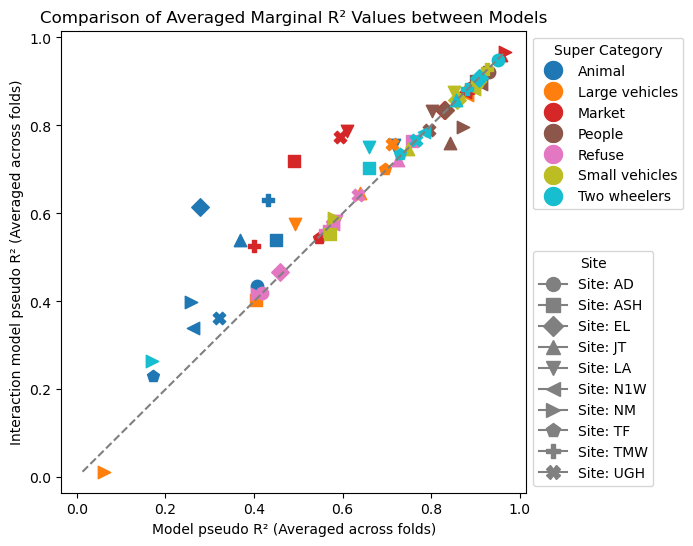

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Load the CSV files
interaction_pseudo_r2_path = './MODEL_RESULTS/interaction_pseudo_r2_results.csv'
pseudo_r2_path = './MODEL_RESULTS/pseudo_r2_results.csv'

# Read both CSV files
interaction_pseudo_r2_df = pd.read_csv(interaction_pseudo_r2_path)
pseudo_r2_df = pd.read_csv(pseudo_r2_path)

# Group by "site" and "super_category" and calculate the average marginal_R2 across folds
interaction_avg_df = interaction_pseudo_r2_df.groupby(['site', 'super_category']).agg(
    avg_marginal_R2_interaction=('marginal_R2', 'mean')).reset_index()

pseudo_r2_avg_df = pseudo_r2_df.groupby(['site', 'super_category']).agg(
    avg_marginal_R2=('marginal_R2', 'mean')).reset_index()

# Merge the two datasets based on "site" and "super_category"
merged_avg_df = pd.merge(interaction_avg_df, pseudo_r2_avg_df, on=['site', 'super_category'])

# Prepare the data for plotting
interaction_values_avg = merged_avg_df['avg_marginal_R2_interaction']
pseudo_r2_values_avg = merged_avg_df['avg_marginal_R2']
categories_avg = merged_avg_df['super_category'].str.replace('_', ' ').str.capitalize()
sites_avg = merged_avg_df['site']

# Create the plot
plt.figure(figsize=(6, 6))

# Use colors for super_category and markers for site
unique_sites_avg = sites_avg.unique()
unique_categories_avg = categories_avg.unique()
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'P', 'X']  # Markers for different sites
colors = plt.cm.get_cmap('tab10', len(unique_categories_avg))

# Create separate legends for super_category and site
for i, category in enumerate(unique_categories_avg):
    category_mask = (categories_avg == category)
    for j, site in enumerate(unique_sites_avg):
        site_mask = (sites_avg == site)
        combined_mask = category_mask & site_mask
        if combined_mask.sum() > 0:  # Only plot if there are values
            plt.scatter(pseudo_r2_values_avg[combined_mask], interaction_values_avg[combined_mask], 
                        color=colors(i), marker=markers[j % len(markers)], 
                        edgecolors=None, s = 80)

# Add the dashed x=y reference line
x_vals = np.linspace(min(pseudo_r2_values_avg.min(), interaction_values_avg.min()), 
                     max(pseudo_r2_values_avg.max(), interaction_values_avg.max()), 100)
plt.plot(x_vals, x_vals, '--', color='gray')

# Add axis labels and title
plt.xlabel("Model pseudo R² (Averaged across folds)")
plt.ylabel("Interaction model pseudo R² (Averaged across folds)")
plt.title("Comparison of Averaged Marginal R² Values between Models")

# Create legends for super_category and site
# Custom legend for super_category (colors)
super_category_legend = [Line2D([0], [0], marker='o', color='w', label=f'{cat}', 
                                markerfacecolor=colors(i), markersize=15, markeredgecolor=None) 
                         for i, cat in enumerate(unique_categories_avg)]

# Custom legend for sites (marker styles)
site_legend = [Line2D([0], [0], marker=markers[j % len(markers)], color='gray', label=f'Site: {site}', 
                      markersize=10, markeredgecolor=None) 
               for j, site in enumerate(unique_sites_avg)]

# Add the legends
first_legend = plt.legend(handles=site_legend, title="Site", loc='lower left', bbox_to_anchor=(1, 0))
plt.gca().add_artist(first_legend)  # Add the first legend separately
plt.legend(handles=super_category_legend, title="Super Category", loc='upper left', bbox_to_anchor=(1, 1))

# Save the figure with bbox_inches='tight' to prevent legend cropping
# plt.tight_layout()
plt.savefig('./results/scatter_plot_avg_with_legend.png', bbox_inches='tight')

# Show the plot
plt.show()